In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
with open('TrainData/train.pkl', 'rb') as f:
    train = pickle.load(f)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('ReportedFraud', axis=1), train['ReportedFraud'], test_size=0.2, random_state=42)

In [5]:
recall_1 = make_scorer(recall_score, pos_label=1)

In [6]:
params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 400, 600, 1000],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.1, 0.2, 0.5, 1],
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=4, verbosity=1)
xgb_rand = RandomizedSearchCV(xgb_model, params, cv=5, n_iter=200, scoring=recall_1, n_jobs=1, verbose=1)
xgb_rand.fit(X_train, y_train)

res = pd.DataFrame(xgb_rand.cv_results_)
res.sort_values(by='rank_test_score').head(10)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
97,19.843470,0.591121,0.050615,0.006060,1,1000,8,0.05,0.4,"{'subsample': 1, 'n_estimators': 1000, 'max_de...",0.845968,0.830645,0.835616,0.829032,0.833065,0.834865,0.005982,1
55,14.850242,0.100899,0.051800,0.015654,1,1000,6,0.2,0,"{'subsample': 1, 'n_estimators': 1000, 'max_de...",0.847581,0.829839,0.836422,0.829032,0.829839,0.834543,0.007045,2
50,10.823824,0.395153,0.016685,0.000731,1,600,8,0.3,0.5,"{'subsample': 1, 'n_estimators': 600, 'max_dep...",0.848387,0.827419,0.834811,0.825806,0.835484,0.834381,0.007994,3
100,2.197552,0.033356,0.015908,0.003213,1,100,8,0.2,0.3,"{'subsample': 1, 'n_estimators': 100, 'max_dep...",0.841129,0.829839,0.833199,0.834677,0.832258,0.834220,0.003796,4
15,12.675003,0.223222,0.038815,0.006523,1,1000,5,0.05,0.4,"{'subsample': 1, 'n_estimators': 1000, 'max_de...",0.843548,0.829032,0.835616,0.828226,0.834677,0.834220,0.005514,5
130,10.808907,0.056172,0.032132,0.006145,1,600,7,0.05,0.5,"{'subsample': 1, 'n_estimators': 600, 'max_dep...",0.843548,0.829839,0.834005,0.830645,0.832258,0.834059,0.004955,6
136,6.124103,0.064989,0.022850,0.001378,1,400,6,0.1,0.3,"{'subsample': 1, 'n_estimators': 400, 'max_dep...",0.844355,0.829032,0.834005,0.832258,0.830645,0.834059,0.005407,6
139,4.802922,0.036462,0.021153,0.000492,1,200,9,0.2,0.1,"{'subsample': 1, 'n_estimators': 200, 'max_dep...",0.845161,0.828226,0.830782,0.831452,0.833065,0.833737,0.005921,8
167,4.547375,0.118120,0.017008,0.001277,1,200,9,0.3,0.3,"{'subsample': 1, 'n_estimators': 200, 'max_dep...",0.845968,0.826613,0.830782,0.830645,0.833065,0.833414,0.006612,9
143,18.332622,0.933659,0.024927,0.001553,1,1000,8,0.3,0.1,"{'subsample': 1, 'n_estimators': 1000, 'max_de...",0.849194,0.825806,0.832393,0.825000,0.833871,0.833253,0.008704,10


In [8]:
xgbc = xgb_rand.best_estimator_
xgbc.fit(X_train, y_train)

y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4184
           1       0.94      0.81      0.87      1584

    accuracy                           0.93      5768
   macro avg       0.93      0.90      0.91      5768
weighted avg       0.93      0.93      0.93      5768



In [10]:
print(confusion_matrix(y_test, y_pred))

[[4098   86]
 [ 298 1286]]


In [11]:
xgb_rand.best_params_   

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.4}

In [13]:
params = {'gamma': [0.3, 0.4, 0.5],
          'learning_rate': [0.03, 0.05, 0.08],
          'subsample': [0.8 , 1],
          'max_depth': [5, 8, 10],
          'n_estimators': [800, 1000, 1200]}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=4, verbosity=1)
xgb_grid = GridSearchCV(xgb_model, params, cv=5, scoring=recall_1, n_jobs=1, verbose=1)
xgb_grid.fit(X_train, y_train)

res = pd.DataFrame(xgb_grid.cv_results_)
res.sort_values(by='rank_test_score').head(10)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,15.610437,0.103718,0.038808,0.000399,0.3,0.05,5,1200,0.8,"{'gamma': 0.3, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.838034,0.830645,0.834677,0.835994,0.005702,1
145,9.615319,0.069023,0.026611,0.002067,0.5,0.08,5,800,1,"{'gamma': 0.5, 'learning_rate': 0.08, 'max_dep...",0.843548,0.829032,0.834005,0.832258,0.837097,0.835188,0.004928,2
20,13.120252,0.061122,0.038109,0.004224,0.3,0.05,5,1000,0.8,"{'gamma': 0.3, 'learning_rate': 0.05, 'max_dep...",0.844355,0.829839,0.836422,0.829839,0.835484,0.835188,0.005345,3
147,11.702861,0.175825,0.028806,0.002994,0.5,0.08,5,1000,1,"{'gamma': 0.5, 'learning_rate': 0.08, 'max_dep...",0.842742,0.829032,0.834005,0.832258,0.837097,0.835027,0.004657,4
149,13.623364,0.212868,0.028005,0.002757,0.5,0.08,5,1200,1,"{'gamma': 0.5, 'learning_rate': 0.08, 'max_dep...",0.842742,0.829032,0.834005,0.832258,0.837097,0.835027,0.004657,4
81,19.552160,0.425191,0.047810,0.007361,0.4,0.05,8,1000,1,"{'gamma': 0.4, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.835616,0.829032,0.833065,0.834865,0.005982,6
79,15.857811,0.563513,0.047610,0.007891,0.4,0.05,8,800,1,"{'gamma': 0.4, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.835616,0.829032,0.833065,0.834865,0.005982,6
83,22.399502,0.618146,0.048261,0.004556,0.4,0.05,8,1200,1,"{'gamma': 0.4, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.835616,0.829032,0.833065,0.834865,0.005982,6
112,15.500908,0.163504,0.041008,0.001789,0.5,0.03,5,1200,0.8,"{'gamma': 0.5, 'learning_rate': 0.03, 'max_dep...",0.846774,0.829839,0.834005,0.826613,0.836290,0.834704,0.006897,9
7,17.119743,0.450746,0.065066,0.019875,0.3,0.03,8,800,1,"{'gamma': 0.3, 'learning_rate': 0.03, 'max_dep...",0.844355,0.829032,0.834005,0.831452,0.834677,0.834704,0.005223,10


In [15]:
from sklearn.model_selection import cross_val_score

xbgc = xgb_grid.best_estimator_

print(cross_val_score(xbgc, X_train, y_train, cv=5, scoring=recall_1).mean())

0.8359938655090847


In [16]:
xgb_grid.best_params_

{'gamma': 0.3,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 1200,
 'subsample': 0.8}

In [20]:
params = {'gamma': [0.2, 0.3, 0.35],
            'learning_rate': [0.03, 0.05, 0.06],
            'subsample': [0.5, 0.8],
            'max_depth': [2, 3, 5],
            'n_estimators': [1100, 1200, 1400]}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=2, verbosity=1)
xgb_grid = GridSearchCV(xgb_model, params, cv=5, scoring=recall_1, n_jobs=1, verbose=1)

xgb_grid.fit(X_train, y_train)

res = pd.DataFrame(xgb_grid.cv_results_)
res.sort_values(by='rank_test_score').head(10)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,26.410966,0.164229,0.067173,0.001206,0.3,0.05,5,1200,0.8,"{'gamma': 0.3, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.838034,0.830645,0.834677,0.835994,0.005702,1
85,23.780223,0.421307,0.060966,0.000597,0.3,0.05,5,1100,0.8,"{'gamma': 0.3, 'learning_rate': 0.05, 'max_dep...",0.845968,0.830645,0.837228,0.830645,0.833065,0.835510,0.005756,2
89,30.353233,0.205684,0.076020,0.001417,0.3,0.05,5,1400,0.8,"{'gamma': 0.3, 'learning_rate': 0.05, 'max_dep...",0.848387,0.829839,0.836422,0.829839,0.832258,0.835349,0.006949,3
139,24.160187,0.119030,0.063124,0.002137,0.35,0.05,5,1100,0.8,"{'gamma': 0.35, 'learning_rate': 0.05, 'max_de...",0.849194,0.828226,0.837228,0.827419,0.834677,0.835349,0.007865,4
51,26.050768,0.198161,0.066689,0.000755,0.2,0.06,5,1200,0.8,"{'gamma': 0.2, 'learning_rate': 0.06, 'max_dep...",0.842742,0.829839,0.837228,0.832258,0.833871,0.835188,0.004476,5
141,26.104464,0.238915,0.067652,0.000779,0.35,0.05,5,1200,0.8,"{'gamma': 0.35, 'learning_rate': 0.05, 'max_de...",0.846774,0.829032,0.837228,0.828226,0.833871,0.835026,0.006729,6
53,30.236073,0.201737,0.076444,0.000823,0.2,0.06,5,1400,0.8,"{'gamma': 0.2, 'learning_rate': 0.06, 'max_dep...",0.843548,0.829032,0.836422,0.831452,0.833871,0.834865,0.004990,7
143,30.494694,0.268288,0.151127,0.147995,0.35,0.05,5,1400,0.8,"{'gamma': 0.35, 'learning_rate': 0.05, 'max_de...",0.846774,0.827419,0.837228,0.829032,0.833871,0.834865,0.006897,8
49,24.192441,0.125443,0.061459,0.000547,0.2,0.06,5,1100,0.8,"{'gamma': 0.2, 'learning_rate': 0.06, 'max_dep...",0.843548,0.828226,0.837228,0.831452,0.833871,0.834865,0.005248,8
35,31.266782,0.752581,0.077441,0.001514,0.2,0.05,5,1400,0.8,"{'gamma': 0.2, 'learning_rate': 0.05, 'max_dep...",0.847581,0.827419,0.836422,0.829032,0.833065,0.834704,0.007165,10


In [22]:
xgbc = xgb_grid.best_estimator_

scores = cross_val_score(xgbc, X_train, y_train, cv=5, scoring=recall_1)
print(scores)
print(scores.mean())
xgbc.fit(X_train, y_train)
print(classification_report(y_test, xgbc.predict(X_test)))

[0.84596774 0.83064516 0.83803384 0.83064516 0.83467742]
0.8359938655090847
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4184
           1       0.94      0.81      0.87      1584

    accuracy                           0.93      5768
   macro avg       0.94      0.90      0.91      5768
weighted avg       0.93      0.93      0.93      5768



In [25]:
xgbc.fit(X_train, y_train)
print(classification_report(y_test, xgbc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4184
           1       0.94      0.81      0.87      1584

    accuracy                           0.93      5768
   macro avg       0.94      0.90      0.91      5768
weighted avg       0.93      0.93      0.93      5768



In [26]:
xgb_grid.best_params_

{'gamma': 0.3,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 1200,
 'subsample': 0.8}

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve

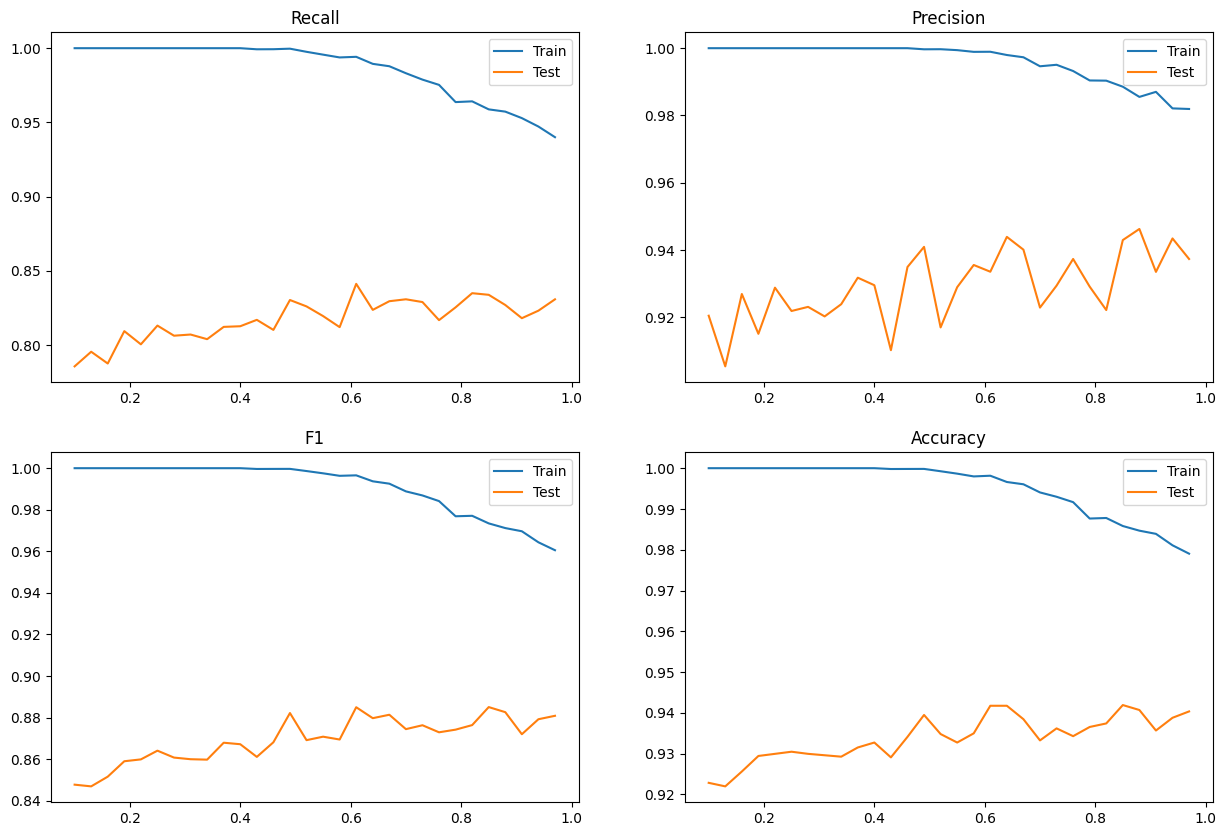

In [34]:
xgbc_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=2, 
                                verbosity=1, gamma=0.3, learning_rate=0.05, 
                                max_depth=5, n_estimators=1200, subsample=0.8)

percent = [_/100 for _ in range(10, 100, 3)]

metrics = {'recall_test': [], 'recall_train': [], 'precision_test': [], 'precision_train': [],
           'f1_test': [], 'f1_train': [], 'accuracy_test': [], 'accuracy_train': []}

for p in percent:
    X_train, X_test, y_train, y_test = train_test_split(train.drop('ReportedFraud', axis=1), 
                                                        train['ReportedFraud'], test_size=0.2)
    X_train = X_train.sample(frac=p)
    y_train = y_train[X_train.index]
    xgbc_model.fit(X_train, y_train)
    metrics['recall_train'].append(recall_1(xgbc_model, X_train, y_train))
    metrics['recall_test'].append(recall_1(xgbc_model, X_test, y_test))
    metrics['precision_train'].append(precision_score(y_train, xgbc_model.predict(X_train)))
    metrics['precision_test'].append(precision_score(y_test, xgbc_model.predict(X_test)))
    metrics['f1_train'].append(f1_score(y_train, xgbc_model.predict(X_train)))
    metrics['f1_test'].append(f1_score(y_test, xgbc_model.predict(X_test)))
    metrics['accuracy_train'].append(accuracy_score(y_train, xgbc_model.predict(X_train)))
    metrics['accuracy_test'].append(accuracy_score(y_test, xgbc_model.predict(X_test)))
    
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(percent, metrics['recall_train'], label='Train')
ax[0, 0].plot(percent, metrics['recall_test'], label='Test')
ax[0, 0].legend()
ax[0, 0].set_title('Recall')

ax[0, 1].plot(percent, metrics['precision_train'], label='Train')
ax[0, 1].plot(percent, metrics['precision_test'], label='Test')
ax[0, 1].legend()
ax[0, 1].set_title('Precision')

ax[1, 0].plot(percent, metrics['f1_train'], label='Train')
ax[1, 0].plot(percent, metrics['f1_test'], label='Test')
ax[1, 0].legend()
ax[1, 0].set_title('F1')

ax[1, 1].plot(percent, metrics['accuracy_train'], label='Train')
ax[1, 1].plot(percent, metrics['accuracy_test'], label='Test')
ax[1, 1].legend()
ax[1, 1].set_title('Accuracy')

plt.show()

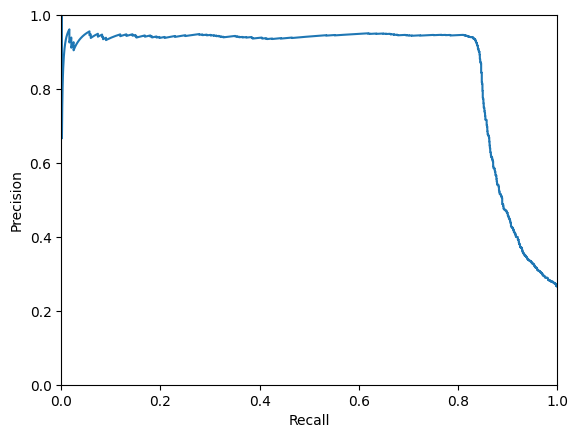

In [45]:
# plot precision-recall curve
precision, recall, threshold = precision_recall_curve(y_test, xgbc_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


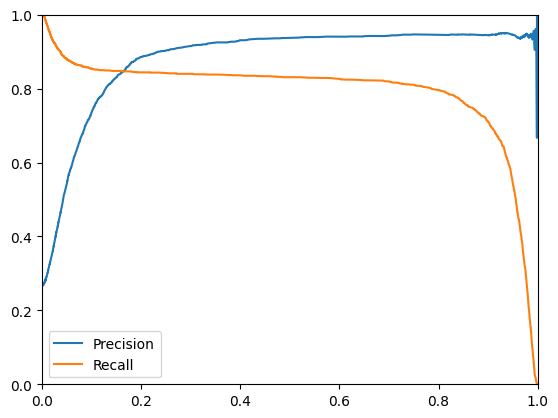

In [48]:
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], label='Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

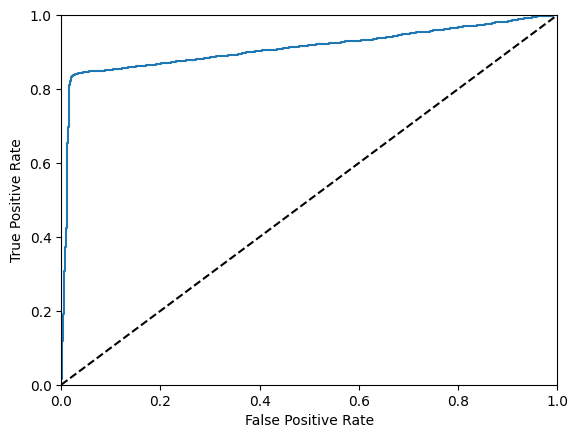

In [49]:
# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, xgbc_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()